Run the following cell to clear your processed data folders

In [48]:
!rm -i data_processed/seg_mask_croped/2013/*  -rf
# !rm -i data_processed/mnt_croped/2013/*  -rf

# Data processing

## TIF image cropping

The dataset is composed of three datasource, all TIF image:
- the `ortho_YEAR.tif.ovr`: the satellite picture of the river
- the `shape_YEAR_tif`: the segmentation mask of the bed ofpebbles
- the `mnt_relatif_YEAR.tif`: the blablablabla # TODO

The tif being too large (71618 x 32460 pixels) to be handled in an np.array, we
will create subimage by cropping the original TIFs, and removing the subimages
containing no data (filled with -inf pixel value)

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

Image.MAX_IMAGE_PIXELS = None

In [7]:
from tqdm import tqdm
import numpy as np

def crop_images(tif_file, tif_cat, output_dir, step_width=541, step_height=385, num_splits_width=60, num_splits_height=186):
    for i in tqdm(range(1, num_splits_width + 1)): # width
        for j in range(1, num_splits_height + 1): # height
            crop_coordinate = ((i-1)*step_width, (j-1)*step_height, i*step_width, j*step_height)
            crop = tif_file.crop(crop_coordinate)
            crop_array = np.array(crop)

            if not len(np.unique(crop_array)) == 1: # toutes les valuers dans l'array sont -inf ou -3.4028235e+38
                np.save(f'{output_dir}/{tif_cat}_{crop_coordinate}.npy', crop_array)

### Orthophoto

In [54]:
### TODO extract ortho as TIF file

In [ ]:
ortho = Image.open("2013/ortho_2013.tif")
ortho.load()

UnidentifiedImageError: cannot identify image file '2013/ortho_2013.tif.ovr'

In [ ]:
del ortho

### Segmentation mask

In [49]:
## TODO rajouter des shutil pour supprimer les dossiers avant de régénérer les données

In [50]:
seg_mask = Image.open("data_raw/2013/shape_2013_tif.tif")
seg_mask.load()

assert(seg_mask.height == 71618)
assert(seg_mask.width == 32460)

In [51]:
crop_images(seg_mask, 'seg_mask', 'data_processed/seg_mask_croped/2013')

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:30<00:00,  1.97it/s]


In [52]:
import os

seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'

seg_mask_crop_list = os.listdir(seg_mask_crop_dir)

print(f'{len(seg_mask_crop_list)} images cropées conservées sur {60*186} générées')
print(f'Les images cropées ont la shape suivante : {np.load(f"{seg_mask_crop_dir}/{seg_mask_crop_list[0]}").shape}')

130 images cropées conservées sur 11160 générées
Les images cropées ont la shape suivante : (385, 541)


In [53]:
del seg_mask

### MNT

In [ ]:
mnt = Image.open("raw_data/2013/mnt_relatif.tif")
mnt.load()


##### TODO mettre tous le code de description des caractéristiques des images dans la première section de preprocessing

print(f'Height of the picture: {mnt.height}, width: {mnt.width}')
assert(mnt.height == 71618)
assert(mnt.width == 32460)

print(f'Width of croped img: {32460/60}')
step_width = int(mnt.width/60)

print(f'Height of croped img (removing 8 pixels to be able to divide it with int): {(71618-8)/186}')
setp_height = int((mnt.height-8)/186)

Height of the picture: 71618, width: 32460
Width of croped img: 541.0
Height of croped img (removing 8 pixels to be able to divide it with int): 385.0


In [ ]:
crop_images(mnt, 'mnt', 'data_processed/mnt_croped/2013')

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:08<00:00,  6.93it/s]


In [ ]:
import os
import numpy as np

mnt_crop_dir = 'data_processed/mnt_croped/2013'

mnt_crop_list = os.listdir(mnt_crop_dir)

print(f'{len(mnt_crop_list)} images cropées conservées sur {60*186} générées')
print(f'Les images cropées ont la shape suivante : {np.load(f"{mnt_crop_dir}/{mnt_crop_list[0]}").shape}')

523 images cropées conservées sur 11160 générées
Les images cropées ont la shape suivante : (385, 541)


In [10]:
del mnt

NameError: name 'mnt' is not defined

### Creation of missing segmask

Only 130 out of the 523 needed segmasks were creating via cropping, as most of 
the ortho and mnt crops don't have peebles bed on it. Thus, we will create the 
missing segmasks, filled with 0.

In [54]:
seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'
seg_mask_crop_list = os.listdir(seg_mask_crop_dir)

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)


crop_shape = (385, 541)

for mnt in mnt_crop_list:
    crop_coordinate = mnt.split('_')[-1].split('.')[0]

    seg_mask_exist = False

    for seg_mask in seg_mask_crop_list:
        if crop_coordinate in seg_mask:
            seg_mask_exist = True
            break

    if not seg_mask_exist:
        seg_mask = np.zeros(crop_shape)
        np.save(f'{seg_mask_crop_dir}/seg_mask_{crop_coordinate}.npy', seg_mask)


Let's check that we have the same number of crops and at the same coordinates

In [55]:
seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'
seg_mask_crop_list = os.listdir(seg_mask_crop_dir)
seg_mask_crop_list.sort()

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)
mnt_crop_list.sort()

assert len(mnt_crop_list) == len(seg_mask_crop_list)

for seg_mask, mnt in zip(seg_mask_crop_list, mnt_crop_list):
    seg_mask_coord = seg_mask.split('_')[-1].split('.')[0]
    mnt_coord = mnt.split('_')[-1].split('.')[0]

    assert seg_mask_coord == mnt_coord

### Checking data type

#### Seg masks

In [56]:
import pandas as pd

seg_mask_dict = {}

for seg_mask in seg_mask_crop_list:
    unique_ids = np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask}'))
    if len(unique_ids) in seg_mask_dict.keys():
        seg_mask_dict[len(unique_ids)] += 1
    else:
        seg_mask_dict.update({len(unique_ids): 1})

In [57]:
df = pd.DataFrame.from_dict(seg_mask_dict, orient='index').reset_index()
df.columns = ["number_of_peebles_bed", "number_of_croped_seg_mask"]
df['number_of_peebles_bed'] -= 1
df.sort_values(by='number_of_croped_seg_mask', ascending=False)

,number_of_peebles_bed,number_of_croped_seg_mask
1,0,393
0,1,85
2,2,35
3,3,8
4,4,2


The vast majority of segmask don't have any peebles - this a point to keep in mind during training.

Let's check the array of the some segmentation masks

In [58]:
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[25]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[291]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[450]}')))

[ 0 76 77]
[ 0 73]
[ 0 94]
[0.]


For the segmasks ids, 0 correspond to the background and the other integers to the id of the pebbles bed. To perform instance segmentation we have to give all pebble beds the same id.

In [60]:
import os
import numpy as np

for seg_mask in seg_mask_crop_list:
    seg_mask_arr = np.load(f'{seg_mask_crop_dir}/{seg_mask}')
    seg_mask_arr = np.where(seg_mask_arr > 0, 1, seg_mask_arr)
    np.save(f'{seg_mask_crop_dir}/{seg_mask}', seg_mask_arr)

In [61]:
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[25]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[291]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[450]}')))

[0 1]
[0 1]
[0 1]
[0.]


Tous les ids des lits de graviers ont bien été passés à 1.

#### Mnt

Let's laod a croped mnt

In [121]:
mnt = np.unique(np.load(f'{mnt_crop_dir}/{mnt_crop_list[0]}'))

np.min(mnt)

np.float32(-3.4028235e+38)

In [126]:
real_min = 0

for mnt in mnt_crop_list:
    mnt_arr = np.load(f'{mnt_crop_dir}/{mnt}')
    mnt_min = np.min(mnt_arr[mnt_arr > -1e6])
    if mnt_min < real_min:
        real_min = mnt_min

real_min


np.float32(-4.151123)

There is some `-inf` value where the mnt was not calculated. The real min is `-4.15`. We will replace these `-inf` values by `np.nan`.

In [127]:
for mnt in mnt_crop_list:
    mnt_arr = np.load(f'{mnt_crop_dir}/{mnt}')
    mnt_arr = np.where(mnt_arr < -1, np.nan, mnt_arr)
    np.save(f'{mnt_crop_dir}/{mnt}', mnt_arr)

## Visualisation

seg_mask_(0, 1155, 541, 1540).npy mnt_(0, 1155, 541, 1540).npy


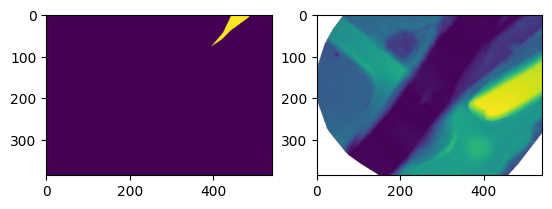

In [128]:
import matplotlib.pyplot as plt
from PIL import Image

seg_mask = np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[0]}')
mnt = np.load(f'{mnt_crop_dir}/{mnt_crop_list[0]}')

print(seg_mask_crop_list[0], mnt_crop_list[0])

f, axarr = plt.subplots(1,2)
axarr[0].imshow(seg_mask)
axarr[1].imshow(mnt)